In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
df_names = pd.read_excel("Names.xlsx")
df_medical = pd.read_csv("Medical Examinations.csv")
df_hospitalization = pd.read_csv("Hospitalisation details.csv")

In [3]:
# merge three tables in one table 
df_collate = pd.merge(df_names, df_medical, on="Customer ID", how= "left")
df_collate = pd.merge(df_collate, df_hospitalization, on="Customer ID", how="left")
df_collate.head(10)

,Customer ID,name,BMI,HBA1C,Heart Issues,Any Transplants,Cancer history,NumberOfMajorSurgeries,smoker,year,month,date,children,charges,Hospital tier,City tier,State ID
0,Id1,"Hawks, Ms. Kelly",47.410,7.47,No,No,No,No major surgery,yes,1968,Oct,12,0,63770.43,tier - 1,tier - 3,R1013
1,Id2,"Lehner, Mr. Matthew D",30.360,5.77,No,No,No,No major surgery,yes,1977,Jun,8,0,62592.87,tier - 2,tier - 3,R1013
2,Id3,"Lu, Mr. Phil",34.485,11.87,yes,No,No,2,yes,1970,?,11,3,60021.40,tier - 1,tier - 1,R1012
3,Id4,"Osborne, Ms. Kelsey",38.095,6.05,No,No,No,No major surgery,yes,1991,Jun,6,1,58571.07,tier - 1,tier - 3,R1024
4,Id5,"Kadala, Ms. Kristyn",35.530,5.45,No,No,No,No major surgery,yes,1989,Jun,19,0,55135.40,tier - 1,tier - 2,R1012
5,Id6,"Baker, Mr. Russell B.",32.800,6.59,No,No,No,No major surgery,yes,1962,Aug,4,0,52590.83,tier - 1,tier - 3,R1011
6,Id7,"Macpherson, Mr. Scott",36.400,6.07,No,No,No,No major surgery,yes,1994,Oct,27,1,51194.56,tier - 1,tier - 3,R1011
7,Id8,"Hallman, Mr. Stephen",36.960,7.93,No,No,No,3,yes,1958,Jun,27,2,49577.66,tier - 2,tier - 2,R1013
8,Id9,"Moran, Mr. Patrick R.",41.140,9.58,yes,No,Yes,1,yes,1963,Sep,4,1,48970.25,tier - 1,tier - 2,R1013
9,Id10,"Benner, Ms. Brooke N.",38.060,10.79,No,No,No,No major surgery,yes,1978,Dec,29,0,48885.14,tier - 1,tier - 2,R1013


In [4]:
df_collate.isnull().sum()


Customer ID               0
name                      0
BMI                       0
HBA1C                     0
Heart Issues              0
Any Transplants           0
Cancer history            0
NumberOfMajorSurgeries    0
smoker                    0
year                      0
month                     0
date                      0
children                  0
charges                   0
Hospital tier             0
City tier                 0
State ID                  0
dtype: int64

In [5]:
df_collate_trivial = df_collate.isin(["?"]).any(axis=1)
df_collate_trivial_percentage = df_collate_trivial.mean()*100
print(f"Percnetage of rows which contains trivial values, {df_collate_trivial_percentage:.2f}%")

Percnetage of rows which contains trivial values, 0.43%


In [6]:
print(len(df_collate))
df_collate_clean = df_collate[~df_collate_trivial]
print(len(df_collate_clean))

2335
2325


In [7]:

df_collate_clean["year"] = df_collate_clean["year"].astype("Int64")
ord_enc = OrdinalEncoder()
df_encoded = df_collate_clean.copy()
# ENcode hospital tier and city tier and others
df_encoded["Hospital tier"] = ord_enc.fit_transform(df_encoded[["Hospital tier"]])
df_encoded["City tier"] = ord_enc.fit_transform(df_encoded[["City tier"]])

label_enc = LabelEncoder()
cols_to_encode = ["Heart Issues", "Any Transplants", "smoker", "Cancer history"]
for col in cols_to_encode:
    df_encoded[col] = label_enc.fit_transform(df_encoded[col])
    
    
month_mapping = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4,
    "May": 5, "Jun": 6, "Jul": 7, "Aug": 8,
    "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}
df_encoded["month"] = df_encoded["month"].map(month_mapping)
# place 0 in place of no major surgery
df_encoded["NumberOfMajorSurgeries"] = (
    df_encoded["NumberOfMajorSurgeries"]
    .replace({"No major surgery": 0,})
    .astype(int)
)
print(df_encoded.dtypes)

Customer ID                object
name                       object
BMI                       float64
HBA1C                     float64
Heart Issues                int64
Any Transplants             int64
Cancer history              int64
NumberOfMajorSurgeries      int64
smoker                      int64
year                        Int64
month                       int64
date                        int64
children                    int64
charges                   float64
Hospital tier             float64
City tier                 float64
State ID                   object
dtype: object


/tmp/ipykernel_139/40014312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collate_clean["year"] = df_collate_clean["year"].astype("Int64")


In [8]:
state_dummies = pd.get_dummies(df_encoded["State ID"], prefix="State")

state_dummies = state_dummies[["State_R1011", "State_R1012", "State_R1013"]]

df_encoded = pd.concat([df_encoded, state_dummies], axis=1)

# Drop original State ID column
df_encoded = df_encoded.drop(columns=["State ID"])
print(df_encoded.head())
print(df_encoded.dtypes)

  Customer ID                    name     BMI  HBA1C  Heart Issues  \
0         Id1       Hawks, Ms.  Kelly  47.410   7.47             0   
1         Id2  Lehner, Mr.  Matthew D  30.360   5.77             0   
3         Id4    Osborne, Ms.  Kelsey  38.095   6.05             0   
4         Id5    Kadala, Ms.  Kristyn  35.530   5.45             0   
5         Id6  Baker, Mr.  Russell B.  32.800   6.59             0   

   Any Transplants  Cancer history  NumberOfMajorSurgeries  smoker  year  \
0                0               0                       0       1  1968   
1                0               0                       0       1  1977   
3                0               0                       0       1  1991   
4                0               0                       0       1  1989   
5                0               0                       0       1  1962   

   month  date  children   charges  Hospital tier  City tier  State_R1011  \
0     10    12         0  63770.43           

In [9]:
# find age from date of birth
df_encoded["DOB"] = pd.to_datetime(
    dict(year=df_encoded["year"], month=df_encoded["month"], day=df_encoded["date"]),
    errors="coerce"
)
today = pd.to_datetime("today")
df_encoded["Age"] = (today - df_encoded["DOB"]).astype("<m8[Y]").astype(int)
df_encoded = df_encoded.drop(columns= ["DOB"])
print(df_encoded.head())
print(df_encoded.dtypes)

  Customer ID                    name     BMI  HBA1C  Heart Issues  \
0         Id1       Hawks, Ms.  Kelly  47.410   7.47             0   
1         Id2  Lehner, Mr.  Matthew D  30.360   5.77             0   
3         Id4    Osborne, Ms.  Kelsey  38.095   6.05             0   
4         Id5    Kadala, Ms.  Kristyn  35.530   5.45             0   
5         Id6  Baker, Mr.  Russell B.  32.800   6.59             0   

   Any Transplants  Cancer history  NumberOfMajorSurgeries  smoker  year  \
0                0               0                       0       1  1968   
1                0               0                       0       1  1977   
3                0               0                       0       1  1991   
4                0               0                       0       1  1989   
5                0               0                       0       1  1962   

   month  date  children   charges  Hospital tier  City tier  State_R1011  \
0     10    12         0  63770.43           

In [10]:
# check gender 
def extract_gender(name):
    if pd.isnull(name):
        return None
    parts = name.split(',')
    if len(parts) > 1:
        after_comma = parts[1].strip().lower()
    else:
        after_comma = name.lower()
    
    
    if after_comma.startswith("mr"):
        return "Male"
    elif after_comma.startswith(("mrs", "ms", "mrs")):
        return "Female"
    else:
        return "Unknown"
    
df_encoded["Gender"] = df_encoded["name"].apply(extract_gender)
df_encoded["Gender"] = df_encoded["Gender"].map({"Male": 1, "Female": 0, "Unknown": -1})
print(df_encoded.head())


  Customer ID                    name     BMI  HBA1C  Heart Issues  \
0         Id1       Hawks, Ms.  Kelly  47.410   7.47             0   
1         Id2  Lehner, Mr.  Matthew D  30.360   5.77             0   
3         Id4    Osborne, Ms.  Kelsey  38.095   6.05             0   
4         Id5    Kadala, Ms.  Kristyn  35.530   5.45             0   
5         Id6  Baker, Mr.  Russell B.  32.800   6.59             0   

   Any Transplants  Cancer history  NumberOfMajorSurgeries  smoker  year  ...  \
0                0               0                       0       1  1968  ...   
1                0               0                       0       1  1977  ...   
3                0               0                       0       1  1991  ...   
4                0               0                       0       1  1989  ...   
5                0               0                       0       1  1962  ...   

   date  children   charges  Hospital tier  City tier  State_R1011  \
0    12         0  637

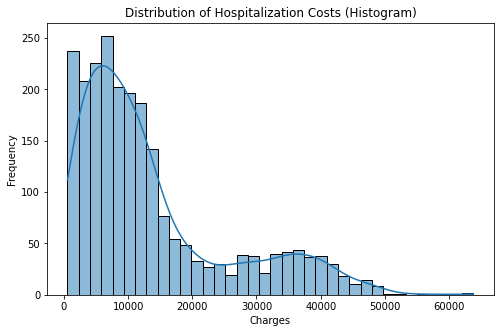

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df_encoded["charges"], kde=True)
plt.title("Distribution of Hospitalization Costs (Histogram)")
plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.show()

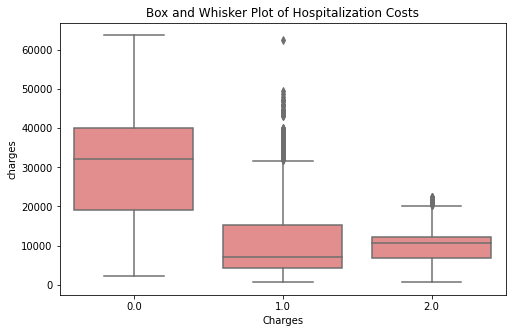

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Hospital tier", y="charges",data = df_encoded, color='lightcoral')
plt.title("Box and Whisker Plot of Hospitalization Costs")
plt.xlabel("Charges")
plt.show()

This plot shows that ties1 hospitals have expensive for the patients and wider graph but tier 2 and tier 3 has lower costs for most of the patients.
It means hospital tiers has a strong affect on charges.

/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 37.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 32.5% of the points cannot be place

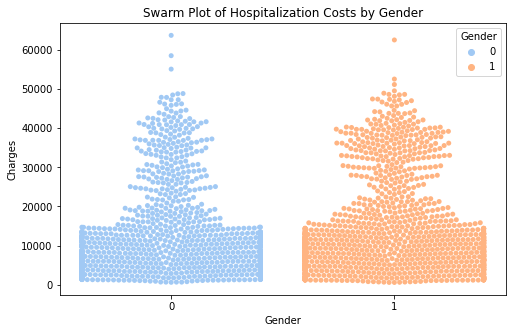

In [13]:
plt.figure(figsize=(8,5))
sns.swarmplot(x="Gender", y="charges", data=df_encoded, palette="pastel", hue="Gender")
plt.title("Swarm Plot of Hospitalization Costs by Gender")
plt.xlabel("Gender")
plt.ylabel("Charges")
plt.show()

This gender plot shows almost same output . Both have outliers too but there is no major difference between male and female costs. 
It means gender has no major affect on charges.

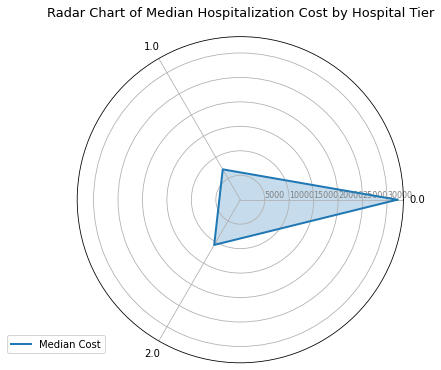

In [14]:
median_costs = df_encoded.groupby("Hospital tier")["charges"].median()

categories = median_costs.index.astype(str)
values = median_costs.values
values = np.concatenate((values, [values[0]]))  # close the circle
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories)

ax.plot(angles, values, linewidth=2, linestyle='solid', label="Median Cost")
ax.fill(angles, values, alpha=0.25)

plt.title("Radar Chart of Median Hospitalization Cost by Hospital Tier", size=13, pad=20)
ax.set_rlabel_position(0)
plt.yticks(color="grey", size=8)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


Frequency Table:
Hospital tier  0.0  1.0  2.0
City tier                   
0.0             85  403  241
1.0            106  479  222
2.0            109  452  228


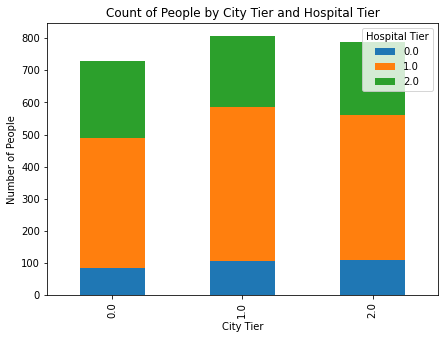

In [15]:
freq_table = pd.crosstab(df_encoded["City tier"], df_encoded["Hospital tier"])
print("Frequency Table:")
print(freq_table)
freq_table.plot(kind="bar", stacked=True, figsize=(7, 5))
plt.title("Count of People by City Tier and Hospital Tier")
plt.xlabel("City Tier")
plt.ylabel("Number of People")
plt.legend(title="Hospital Tier")
plt.show()


In [16]:
from scipy.stats import f_oneway,ttest_ind,chi2_contingency
tier1 = df_encoded[df_encoded["Hospital tier"] == 0.0]["charges"]
tier2 = df_encoded[df_encoded["Hospital tier"] == 1.0]["charges"]
tier3 = df_encoded[df_encoded["Hospital tier"] == 2.0]["charges"]

f_stat, p_value = f_oneway(tier1, tier2, tier3)
print("ANOVA for Hospital Tiers")
print("F-statistic:", f_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print(" Reject H₀ → Significant difference between hospital tiers.")
else:
    print(" Fail to reject H₀ → No significant difference between hospital tiers.")


ANOVA for Hospital Tiers
F-statistic: 493.989566311176
p-value: 1.7738221310855688e-179
 Reject H₀ → Significant difference between hospital tiers.


In [17]:
city1 = df_encoded[df_encoded["City tier"] == 0]["charges"]
city2 = df_encoded[df_encoded["City tier"] == 1]["charges"]
city3 = df_encoded[df_encoded["City tier"] == 2]["charges"]

f_stat, p_value = f_oneway(city1, city2, city3)
print("\nANOVA for City Tiers")
print("F-statistic:", f_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject H₀ → Significant difference between city tiers.")
else:
    print("Fail to reject H₀ → No significant difference between city tiers.")



ANOVA for City Tiers
F-statistic: 1.454355756181466
p-value: 0.23376344386881315
Fail to reject H₀ → No significant difference between city tiers.


In [18]:
smokers = df_encoded[df_encoded["smoker"] == 1]["charges"]
non_smokers = df_encoded[df_encoded["smoker"] == 0]["charges"]

t_stat, p_value = ttest_ind(smokers, non_smokers, equal_var=False)
print("\nT-test for Smokers vs Non-Smokers")
print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Reject H₀ → Significant difference in costs between smokers and non-smokers.")
else:
    print("Fail to reject H₀ → No significant difference in costs between smokers and non-smokers.")



T-test for Smokers vs Non-Smokers
t-statistic: 56.316832285932286
p-value: 6.697431845033993e-238
Reject H₀ → Significant difference in costs between smokers and non-smokers.


In [19]:
contingency = pd.crosstab(df_encoded["smoker"], df_encoded["Heart Issues"])

chi2, p, dof, expected = chi2_contingency(contingency)
print("\nChi-Square Test for Independence (Smoking vs Heart Issues)")
print("Chi2 Statistic:", chi2)
print("p-value:", p)

if p < 0.05:
    print("Reject H₀ → Smoking and heart issues are dependent.")
else:
    print("Fail to reject H₀ → Smoking and heart issues are independent.")



Chi-Square Test for Independence (Smoking vs Heart Issues)
Chi2 Statistic: 0.08588150449910657
p-value: 0.7694797581780767
Fail to reject H₀ → Smoking and heart issues are independent.


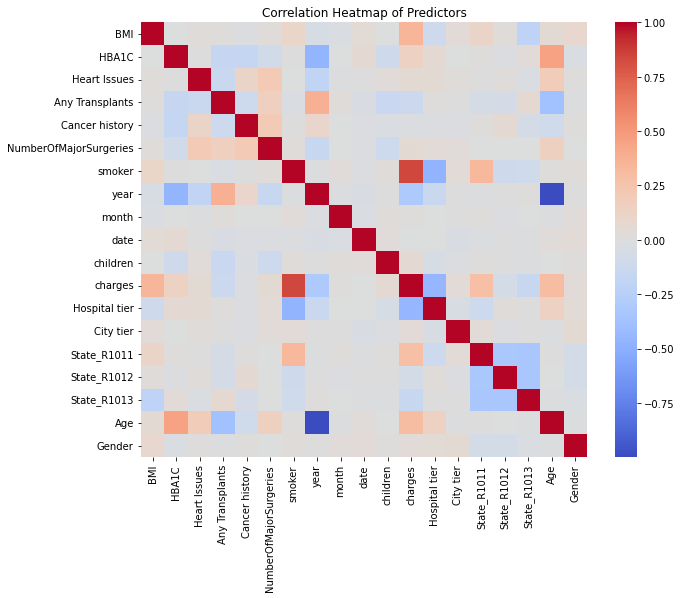

  Variable 1 Variable 2  Correlation
0     smoker    charges     0.838462
1    charges     smoker     0.838462
      BMI  HBA1C  Heart Issues  Any Transplants  Cancer history  \
0  47.410   7.47             0                0               0   
1  30.360   5.77             0                0               0   
3  38.095   6.05             0                0               0   
4  35.530   5.45             0                0               0   
5  32.800   6.59             0                0               0   

   NumberOfMajorSurgeries  smoker  year  month  date  children   charges  \
0                       0       1  1968     10    12         0  63770.43   
1                       0       1  1977      6     8         0  62592.87   
3                       0       1  1991      6     6         1  58571.07   
4                       0       1  1989      6    19         0  55135.40   
5                       0       1  1962      8     4         0  52590.83   

   Hospital tier  City tier  

In [20]:
numeric_df = df_encoded.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Predictors")
plt.show()
# Find highly correlated pairs (above 0.7)
threshold = 0.7
high_corr = corr_matrix[(corr_matrix > threshold) & (corr_matrix < 1.0)].stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
print(high_corr)
df_encoded = df_encoded.drop(columns=["Customer ID", "name"])
print(df_encoded.head())

In [21]:
df_copy = df_encoded.copy()
X = df_copy.drop(columns=["charges"]) 
y = df_copy["charges"]   

df_copy["charges_strata"] = pd.qcut(y, q=5, labels=False)
 # Stratified 5-Fold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = stratified_kfold.split(X, df_copy["charges_strata"])

pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("ridge", Ridge())             
])
param_grid = {
    "ridge__alpha": [0.01, 0.1, 1, 10, 100]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=list(splits),
    scoring="neg_mean_squared_error"
)
grid_search.fit(X, y)

print("Best alpha:", grid_search.best_params_)
print("Best score (MSE):", -grid_search.best_score_)

# Assign each sample a fold number
folds = np.zeros(len(X))
for fold_number, (_, test_index) in enumerate(stratified_kfold.split(X, df_copy["charges_strata"])):
    folds[test_index] = fold_number
df_copy["fold"] = folds
print(df_copy.head()) 

Best alpha: {'ridge__alpha': 10}
Best score (MSE): 20031794.65301039
      BMI  HBA1C  Heart Issues  Any Transplants  Cancer history  \
0  47.410   7.47             0                0               0   
1  30.360   5.77             0                0               0   
3  38.095   6.05             0                0               0   
4  35.530   5.45             0                0               0   
5  32.800   6.59             0                0               0   

   NumberOfMajorSurgeries  smoker  year  month  date  ...   charges  \
0                       0       1  1968     10    12  ...  63770.43   
1                       0       1  1977      6     8  ...  62592.87   
3                       0       1  1991      6     6  ...  58571.07   
4                       0       1  1989      6    19  ...  55135.40   
5                       0       1  1962      8     4  ...  52590.83   

   Hospital tier  City tier  State_R1011  State_R1012  State_R1013  Age  \
0            0.0        2.

In [37]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = stratified_kfold.split(X, df_copy["charges_strata"])
final_model = grid_search.best_estimator_
# store ridge model and scaler from pipelline for future use for prediction 
ridge_model = grid_search.best_estimator_.named_steps["ridge"]
scaler = grid_search.best_estimator_.named_steps["scaler"]

scores = cross_val_score(final_model, X, y,
                         cv=list(splits),
                         scoring="neg_mean_squared_error")

rmse_scores = np.sqrt(-scores)

print("RMSE for each fold:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())


RMSE for each fold: [4354.75958545 4218.64457303 4530.43198599 4690.4382199  4568.70392015]
Average RMSE: 4472.595656905199


In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X, y)

#  Feature importance
importance = gb_model.feature_importances_

# Display top 10 important variables
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))


          Feature  Importance
6          smoker    0.750100
0             BMI    0.111468
7            year    0.054249
16            Age    0.038538
11  Hospital tier    0.021775
13    State_R1011    0.007634
10       children    0.006057
15    State_R1013    0.004370
1           HBA1C    0.002768
9            date    0.001184


In [34]:
from datetime import date
weight = 85
height_in_meters = 170/100
BMI = weight / (height_in_meters ** 2)

dob = date(1988, 12, 28)
today = date.today()
age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
print(age)
print(BMI)
print(df_copy.columns)

36
29.411764705882355
Index(['BMI', 'HBA1C', 'Heart Issues', 'Any Transplants', 'Cancer history',
       'NumberOfMajorSurgeries', 'smoker', 'year', 'month', 'date', 'children',
       'charges', 'Hospital tier', 'City tier', 'State_R1011', 'State_R1012',
       'State_R1013', 'Age', 'Gender', 'charges_strata', 'fold'],
      dtype='object')


In [46]:
christopher = pd.DataFrame([{
    "BMI": 29.41,
    "HBA1C": 5.8,
    "Heart Issues": 0,
    "Any Transplants": 0,
    "Cancer history": 1,
    "NumberOfMajorSurgeries": 0,
    "smoker": 1,
    "year": 1988,
    "month": 12,
    "date": 28,
    "children": 2,
    "Hospital tier": 1,
    "City tier": 1,
    "State_R1011": 1,
    "State_R1012": 0,
    "State_R1013": 0,
    "Age": 36,
    "Gender": 1
}])
christopher_scaled = scaler.transform(christopher)

# Ridge prediction
ridge_pred = ridge_model.predict(christopher_scaled)[0]

# Gradient Boosting prediction
gb_pred = gb_model.predict(christopher)[0]

print("Predicted hospitalization cost (Ridge):", ridge_pred)
print("Predicted hospitalization cost (Gradient Boost):", gb_pred)


Predicted hospitalization cost (Ridge): 29536.120830774016
Predicted hospitalization cost (Gradient Boost): 26072.070216599997
